In [260]:
words = open('names.txt', 'r').read().splitlines()
chars = ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
symbol_count = len(chars)
stoi = dict([(chars[x], x) for x in range(len(chars))])
itos = dict([(x, chars[x]) for x in range(len(chars))])

xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1,c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{stoi=}\n{itos=}')
print(len(words), 'words')
print(len(xs), ' input letters ', xs[0:5])
print(len(ys), 'labels', ys[0:5])

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
32033 words
228146  input letters  tensor([ 0,  5, 13, 13,  1])
228146 labels tensor([ 5, 13, 13,  1,  0])


torch.Size([228145])


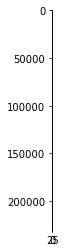

In [291]:
import matplotlib.pyplot as plt
%matplotlib inline

nb_of_examples = -1

inputs = xs[0:nb_of_examples]
outputs = ys[0:nb_of_examples]
print(inputs.shape)
xenc = Fun.one_hot(inputs, num_classes=symbol_count).float()
plt.imshow(xenc)


In [301]:
g = torch.manual_seed(2147483647)
W = torch.randn((symbol_count, symbol_count), generator=g, requires_grad=True)

x = inputs[:5]
xenc = Fun.one_hot(x, num_classes=symbol_count).float()
logits = xenc @ W
counts = logits.exp()

counts,counts.shape, counts.sum(1, keepdims=True) 



(tensor([[ 4.7940,  0.7888,  0.9730,  0.3326,  1.3309,  0.9708,  0.2129,  1.8311,
           1.0824,  2.4710,  0.6242,  2.1964,  0.7200,  0.6486,  3.9469, 18.7908,
           4.7673,  0.1967,  1.9683,  0.4315,  2.6775,  0.8621,  0.2277,  1.5656,
           0.9317, 12.1434, 11.5281],
         [ 1.6038,  4.4060,  1.3737,  2.8830, 11.0032,  1.5972,  0.5187,  1.8527,
           0.5369,  1.6654,  3.8818,  1.2642,  0.6339,  0.9987,  0.5995,  1.7432,
           1.6073,  0.2499,  5.0680,  1.1876,  2.6871,  1.6596,  2.7728,  0.1486,
           0.6521,  0.1193,  2.6128],
         [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
           4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0.5719,  0.4373,
           2.2763,  0.4719,  2.5289,  0.2265,  0.8082,  0.3054,  0.5164,  0.7918,
           4.6866,  1.8232,  0.4921],
         [ 1.2136,  2.8669,  1.8850,  1.2942,  2.6224,  0.7799,  1.0251,  0.9701,
           4.7691,  0.6386,  0.2910,  3.0710,  0.5098,  1.0386,  0

In [307]:
g = torch.manual_seed(2147483647)

def word_gen(W):
    word = ''
    next_char = '.'
    while True:
        # print(f'{next_char=}')
        word += next_char
        xenc = Fun.one_hot(torch.tensor([stoi[next_char]]), num_classes=symbol_count).float()
        logits = xenc @ W
        # softmax our outputs into a probability distribution
        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdims=True)
        # print(probs)
        next_char = itos[torch.multinomial(probs, 1, replacement=True, generator=g).item()]
        if next_char == '.':
            word += '.'
            break
        
    return word


def optimize(inputs, labels, w_adjust, passes):   
    # W = torch.randn((symbol_count, symbol_count), generator=g, requires_grad=True)
    W = torch.ones((symbol_count, symbol_count), requires_grad=True)
    # print(inputs, labels, w_adjust, passes)
    for i in range(passes):
        # forward
        xenc = Fun.one_hot(inputs, num_classes=symbol_count).float()
        logits = xenc @ W
        # softmax our outputs into a probability distribution
        counts = logits.exp()
       
        probs = counts / counts.sum(dim=1, keepdims=True)
        # print(probs)
        # print(torch.arange(len(inputs)))
        # backwards
        # 0.01 * (W**2).mean() is the regularization
        loss = -probs[torch.arange(len(inputs)), labels].log().mean() + 0.01 * (W**2).mean()
        if i % 100 == 0:
            print(i, 'loss:', loss.item())
            for i in range(5):
                w = word_gen(W)
                print('  ',i, w)
        W.grad = None
        loss.backward()
        # update
        W.data += -w_adjust * W.grad
    return W


print(len(inputs), 'inputs', inputs)
print(len(outputs), 'outputs', outputs)
print(symbol_count)
weights = optimize(inputs, outputs, 0.5, 10000)
g = torch.manual_seed(2147483647)
for i in range(10):
    w = word_gen(weights)
    print(i, w)

228145 inputs tensor([ 0,  5, 13,  ..., 26, 25, 26])
228145 outputs tensor([ 5, 13, 13,  ..., 25, 26, 24])
27
0 loss: 3.305837392807007
   0 .qvsaayxbqrqmyqwuznivanukotdjvdhd.
   1 .qnoymtzduqkatdetkpfjdgigvlejfkrsqlwnirghhzwlu.
   2 .idcx.
   3 .cekmzucjnjoeovjvrggqrjr.
   4 .cfbhabkslpokc.
100 loss: 3.0796680450439453
   0 .xtxwbpmjntusxdgzfexhwqpldpdnwzvjyxsqjforqqpfxstvkfoufhvwfhlruyynsvcvvqqfcbydibouhjaijhqnloqmmlkanqdqy.
   1 .gszpw.
   2 .zlfiiin.
   3 .mgzzuulryuqrufuawausdamwvllqypvgrrefpshfmmwaeplricvbgnduojhfxhkwcltrdjwn.
   4 .gzykmqv.
200 loss: 2.937119483947754
   0 .kersdqjgun.
   1 .cojcdtstjfdo.
   2 .adokrxeojbslhwguzer.
   3 .voflejxflyle.
   4 .dfpjcpntcsvablzyrptragxhabn.
300 loss: 2.846243381500244
   0 .guum.
   1 .vtyqle.
   2 .ka.
   3 .ma.
   4 .lyinihtukelar.
400 loss: 2.7836146354675293
   0 .sbqcftilizqta.
   1 .gsuwrresnanifgwudciazsqopeienrsxmus.
   2 .ikxencjozbh.
   3 .rieahtjbicawcetkomsivvutxlylrvyjenzaruduxfubon.
   4 .kbdoilgemjhaian.
500 loss: 2.73

7400 loss: 2.4996604919433594
   0 .kxwaarere.
   1 .zwdraloneryah.
   2 .jzicum.
   3 .n.
   4 .komee.
7500 loss: 2.499391794204712
   0 .movavgolen.
   1 .slivylelilirellla.
   2 .leadikabr.
   3 .hx.
   4 .eroneh.
7600 loss: 2.4991300106048584
   0 .eli.
   1 .ka.
   2 .kanaima.
   3 .jhepron.
   4 .elouweist.
7700 loss: 2.498875856399536
   0 .a.
   1 .jos.
   2 .sil.
   3 .hayced.
   4 .zelor.
7800 loss: 2.498628616333008
   0 .yyjare.
   1 .n.
   2 .plee.
   3 .yltasarra.
   4 .pe.
7900 loss: 2.4983878135681152
   0 .enn.
   1 .kerahason.
   2 .kauzffuralimil.
   3 .n.
   4 .an.
8000 loss: 2.4981536865234375
   0 .aayona.
   1 .s.
   2 .melymatra.
   3 .masugh.
   4 .cptays.
8100 loss: 2.4979255199432373
   0 .ph.
   1 .dann.
   2 .keneha.
   3 .jqkel.
   4 .rr.
8200 loss: 2.497703790664673
   0 .e.
   1 .f.
   2 .rigwn.
   3 .hbry.
   4 .wallla.
8300 loss: 2.4974870681762695
   0 .m.
   1 .za.
   2 .s.
   3 .faelamowyayquxstyaresten.
   4 .a.
8400 loss: 2.4972760677337646
   0 .